In [9]:
!pip install tensorflow

In [10]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk

# Download the 'punkt_tab' data package
nltk.download('punkt_tab')

# ... rest of your code ...

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3401 - loss: 1.2692 - val_accuracy: 0.3163 - val_loss: 1.0831
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4017 - loss: 1.0593 - val_accuracy: 0.3163 - val_loss: 1.0878
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.3999 - loss: 1.0692 - val_accuracy: 0.3163 - val_loss: 1.0825
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.3894 - loss: 1.0622 - val_accuracy: 0.3189 - val_loss: 1.0768
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4125 - loss: 1.0494 - val_accuracy: 0.3444 - val_loss: 1.0657
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4309 - loss: 1.0197 - val_accuracy: 0.3827 - val_loss: 1.0120
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.5032 - loss: 0.9613 - val_accuracy: 0.6633 - val_loss: 0.8143
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7402 - loss: 0.6247 - val_accuracy: 0.7500 - va

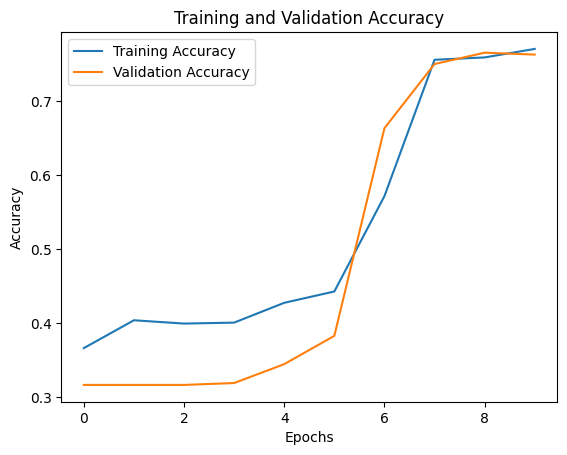

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load your data
data = pd.read_csv('/content/final.csv')

# Preprocess labels (categories)
label_encoder = LabelEncoder()
data['encoded_category'] = label_encoder.fit_transform(data['category'])

# One-hot encode labels
labels = to_categorical(data['encoded_category'], num_classes=3)

# Tokenize captions
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['caption'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['caption'])

# Pad sequences to ensure uniform input size
max_length = 200  # You can adjust this based on the data
X = pad_sequences(sequences, padding='post', maxlen=max_length)

# Split data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a Word2Vec model
tokenized_captions = [caption.split() for caption in data['caption']]  # Split captions into words
w2v_model = Word2Vec(sentences=tokenized_captions, vector_size=200, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((10000, embedding_dim))  # vocab_size = 10000 as defined in tokenizer
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(256, return_sequences=True),  # LSTM layer
    LSTM(256),  # Another LSTM layer
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)

# Step 6: Print final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

# Step 7: Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 849ms/step


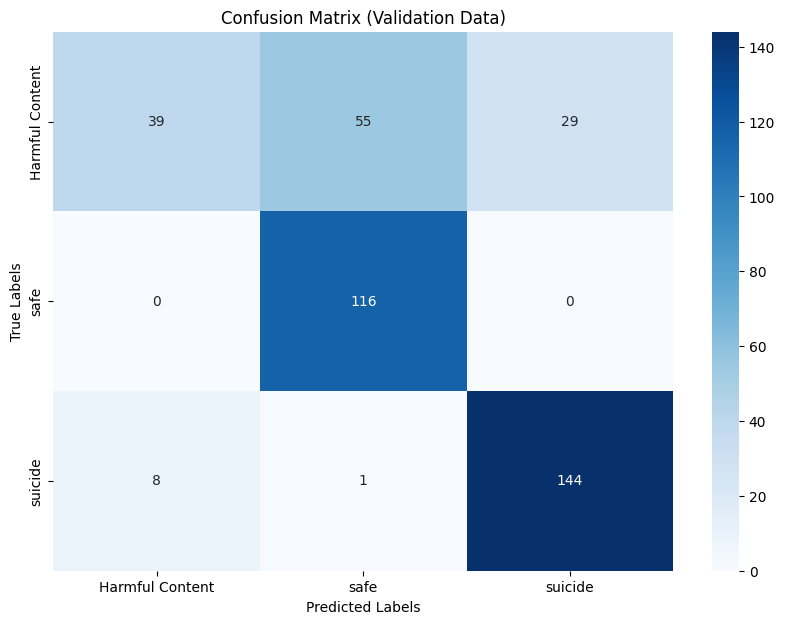

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on validation data
y_pred = model.predict(X_val)  # Use validation data (X_val) instead of test data
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability
y_true_classes = np.argmax(y_val, axis=1)  # Get the true labels from y_val

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Validation Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
